In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# the same as regular one but with shift to grayscale
data_transforms_gray = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'dummy_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
image_datasets_gray = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_gray[x])
                  for x in ['train', 'val']}
# here changing back and forth between grayscale and regular image_datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets_gray[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

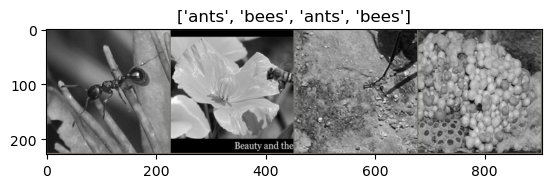

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
num_ftrs

512

In [7]:
model_ft.fc = nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# observe that all parameters are being optimized (what does it mean?)
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.7830 Acc: 0.6434
val Loss: 0.6232 Acc: 0.8105

Epoch 2/25
----------
train Loss: 0.6306 Acc: 0.7500
val Loss: 0.4044 Acc: 0.8301

Epoch 3/25
----------
train Loss: 0.6931 Acc: 0.7418
val Loss: 0.5786 Acc: 0.8235

Epoch 4/25
----------
train Loss: 0.5918 Acc: 0.7541
val Loss: 0.5053 Acc: 0.8039

Epoch 5/25
----------
train Loss: 0.6514 Acc: 0.7500
val Loss: 0.4682 Acc: 0.8431

Epoch 6/25
----------
train Loss: 0.5198 Acc: 0.7992
val Loss: 0.9576 Acc: 0.6797

Epoch 7/25
----------
train Loss: 0.6470 Acc: 0.7623
val Loss: 0.3813 Acc: 0.8627

Epoch 8/25
----------
train Loss: 0.4312 Acc: 0.8361
val Loss: 0.3076 Acc: 0.8824

Epoch 9/25
----------
train Loss: 0.2866 Acc: 0.8934
val Loss: 0.3468 Acc: 0.8824

Epoch 10/25
----------
train Loss: 0.2292 Acc: 0.8934
val Loss: 0.3697 Acc: 0.8889

Epoch 11/25
----------
train Loss: 0.4070 Acc: 0.8320
val Loss: 0.3022 Acc: 0.8954

Epoch 12/25
----------
train Loss: 0.3117 Acc: 0.8689
val Loss: 0.3416 Acc: 0.8889

E

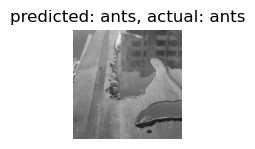

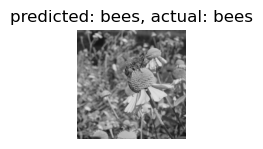

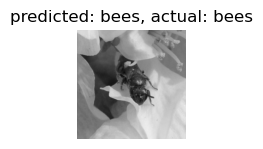

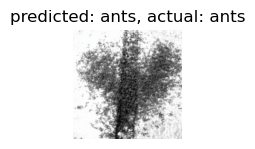

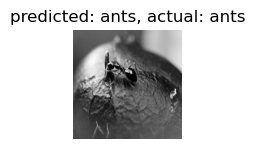

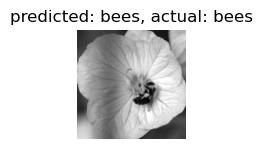

In [9]:
visualize_model(model_ft)

In [10]:
# upl

In [11]:
# here I want to put those bees trough grayscale, put the same image to all three channels and see how it impacts the efficiency


In [12]:
model_152 = models.resnet152(weights='IMAGENET1K_V1')
num_ftrs = model_152.fc.in_features

print(model_152)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
model_152.fc = nn.Linear(num_ftrs, 2)
model_152.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# observe that all parameters are being optimized (what does it mean?)
optimizer_152 = optim.SGD(model_152.parameters(),lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_152, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

model_152 = train_model(model_152, criterion, optimizer_152, exp_lr_scheduler,
                       num_epochs=30)

Epoch 1/30
----------
train Loss: 0.5325 Acc: 0.7213
val Loss: 0.2718 Acc: 0.8954

Epoch 2/30
----------
train Loss: 0.4979 Acc: 0.8074
val Loss: 0.4812 Acc: 0.8235

Epoch 3/30
----------
train Loss: 0.4631 Acc: 0.7992
val Loss: 0.8017 Acc: 0.6863

Epoch 4/30
----------
train Loss: 0.6532 Acc: 0.7459
val Loss: 0.4402 Acc: 0.8497

Epoch 5/30
----------
train Loss: 0.6861 Acc: 0.7623
val Loss: 0.3170 Acc: 0.8889

Epoch 6/30
----------
train Loss: 0.4725 Acc: 0.8156
val Loss: 0.3029 Acc: 0.8824

Epoch 7/30
----------
train Loss: 0.4059 Acc: 0.8484
val Loss: 0.3183 Acc: 0.8758

Epoch 8/30
----------
train Loss: 0.4011 Acc: 0.8443
val Loss: 0.2538 Acc: 0.9150

Epoch 9/30
----------
train Loss: 0.4288 Acc: 0.7910
val Loss: 0.2569 Acc: 0.9020

Epoch 10/30
----------
train Loss: 0.3386 Acc: 0.8525
val Loss: 0.2287 Acc: 0.9150

Epoch 11/30
----------
train Loss: 0.2547 Acc: 0.8852
val Loss: 0.2124 Acc: 0.9281

Epoch 12/30
----------
train Loss: 0.3699 Acc: 0.8279
val Loss: 0.1966 Acc: 0.9346

E

In [18]:
torch.save(model_ft, 'dummy_data/hymenoptera_data/ResNet18_bees_ants_grayscale')

In [19]:
model_loaded = torch.load('dummy_data/hymenoptera_data/ResNet18_bees_ants_grayscale')

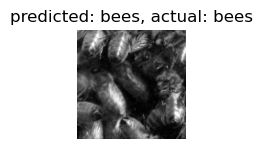

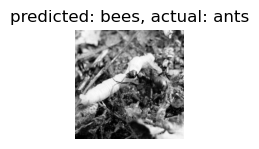

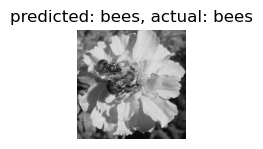

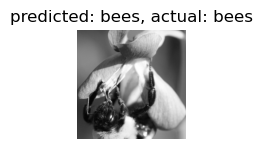

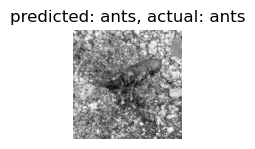

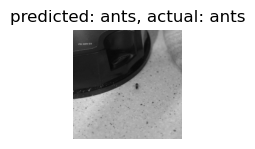

In [20]:
visualize_model(model_loaded)

In [31]:
with torch.no_grad():
    imgs, labels = next(iter(dataloaders['val']))
    imgs = imgs.to(device)
    outputs = model_loaded(imgs)
    wtf, preds = torch.max(outputs,1)

In [65]:
def eval_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        for imgs, labels in dataloaders['val']:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs,1)
            correct += sum(labels.to(device) == preds)
    return correct / dataset_sizes['val']
eval_model(model_loaded)


tensor(0.8954, device='cuda:0')

In [55]:
0 + sum(labels.to(device) == preds) + sum(labels.to(device) == preds)

tensor(6, device='cuda:0')

In [69]:
dataset_sizes['val']

153